# Imports

In [1]:
!pip install idx2numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape
from keras.optimizers import RMSprop

from sklearn.model_selection import train_test_split
import idx2numpy

  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7905 sha256=5115f40bea34ac364cf9026382c62e90aee8fef9052d3373d14e051af4905242
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy


# Data Read and Check

In [2]:
file_path = 'reduce.config'

# extract variables from the file
variables = {}

file = open(file_path, 'r')

for line in file:
    key, value = line.strip().split(':')
    variables[key.strip()] = value.strip()

# access the values for the variables
dataset = variables.get('dataset')
queryset = variables.get('queryset')
output_dataset_file = variables.get('output_dataset_file')
output_query_file = variables.get('output_query_file')

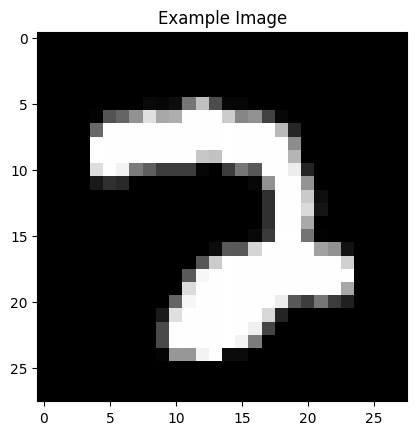

In [3]:
# set data and query paths
data_path = dataset
query_path = queryset

# load data and query from paths
data = idx2numpy.convert_from_file(data_path)
query = idx2numpy.convert_from_file(query_path)

# display the reshaped image
plt.imshow(data[120], cmap='gray')
plt.title("Example Image")
plt.show()

In [4]:
# shape of data set
print("Data set shape: ",data.shape)

# shape of query set
print("Query set shape: ",query.shape)


Data set shape:  (60000, 28, 28)
Query set shape:  (10000, 28, 28)


# Data Preproccessing

Convert from 28x28 to 28x28x1

In [5]:
# underscored data and query hold the postproccessed data, and query sets
_data = data.reshape(-1, 28,28, 1)
_query = query.reshape(-1, 28,28, 1)

In [6]:
# shape of data set
print("Data set shape: ",_data.shape)

# shape of query set
print("Query set shape: ",_query.shape)

Data set shape:  (60000, 28, 28, 1)
Query set shape:  (10000, 28, 28, 1)


Change data type to float32

In [7]:
# change the data type of _data and _query to float32
_data = _data.astype('float32')
_query = _query.astype('float32')

_data.dtype, _query.dtype

(dtype('float32'), dtype('float32'))

Rescale values from [0, 255] to [0.0, 1.0]

In [8]:
np.max(_data), np.max(_query)

(255.0, 255.0)

In [9]:
_data = _data / np.max(_data)
_query = _query / np.max(_query)

In [10]:
np.max(_data), np.max(_query)

(1.0, 1.0)

Split the data into train, valid, ground

In [11]:
train_X,valid_X,train_ground,valid_ground = train_test_split(_data,
                                                             _data,
                                                             test_size=0.181,
                                                             random_state=333)

# Neural Network

In [12]:
# hyperparameters
batch_size = 128 # 128, 256, 512
epochs = 10

# create the input layer
inChannel = 1
x, y = 28, 28
input_img = Input(shape = (x, y, inChannel))

In [13]:
input_img = Input(shape = (x, y, inChannel))

conv_shape = (3, 3)
filters=(64,32,16)

x = Conv2D(filters[0], conv_shape, activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(filters[1], conv_shape, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(filters[2], conv_shape, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

# flatten to prepare for the dense layer
x = Flatten()(x)

# latent space
latent = Dense(10, activation='sigmoid')(x)

# decoder
x = Dense(4 * 4 * 4, activation='relu')(latent)
x = Reshape((4, 4, 4))(x)

x = Conv2D(filters[2], conv_shape, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(filters[1], conv_shape, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(filters[0], conv_shape, activation='relu')(x)
x = UpSampling2D((2, 2))(x)
# output layer
decoded = Conv2D(1, conv_shape, activation='sigmoid', padding='same')(x)

# autoencoder model
autoencoder = Model(input_img, decoded)
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 16)          4624  

In [14]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground))


Epoch 1/10
384/384 [==============================] - 185s 477ms/step - loss: 0.0690 - val_loss: 0.0589
Epoch 2/10
384/384 [==============================] - 182s 475ms/step - loss: 0.0503 - val_loss: 0.0438
Epoch 3/10
384/384 [==============================] - 187s 488ms/step - loss: 0.0409 - val_loss: 0.0393
Epoch 4/10
384/384 [==============================] - 184s 479ms/step - loss: 0.0364 - val_loss: 0.0355
Epoch 5/10
384/384 [==============================] - 185s 481ms/step - loss: 0.0335 - val_loss: 0.0344
Epoch 6/10
384/384 [==============================] - 186s 484ms/step - loss: 0.0315 - val_loss: 0.0291
Epoch 7/10
384/384 [==============================] - 185s 483ms/step - loss: 0.0298 - val_loss: 0.0284
Epoch 8/10
384/384 [==============================] - 186s 484ms/step - loss: 0.0284 - val_loss: 0.0281
Epoch 9/10
384/384 [==============================] - 191s 499ms/step - loss: 0.0274 - val_loss: 0.0269
Epoch 10/10
384/384 [==============================] - 191s 497m

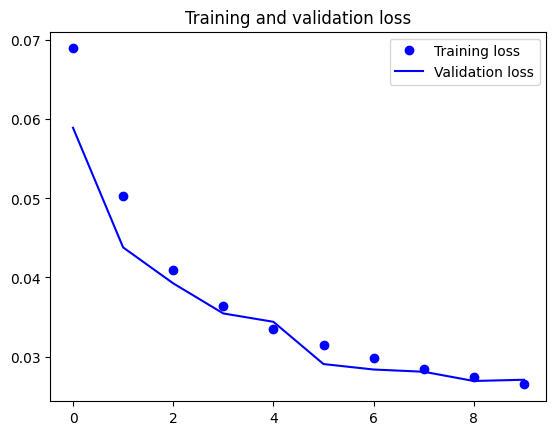

In [15]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [16]:
pred = autoencoder.predict(_query)



313/313 [==============================] - 8s 26ms/step


In [17]:
pred.shape



(10000, 28, 28, 1)

Test Images


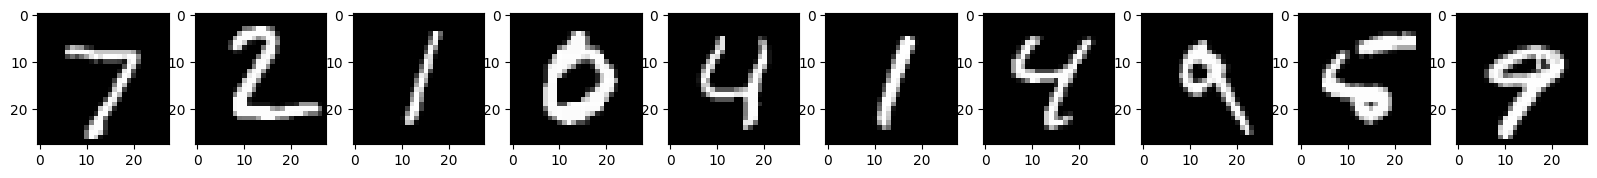

Reconstruction of Test Images


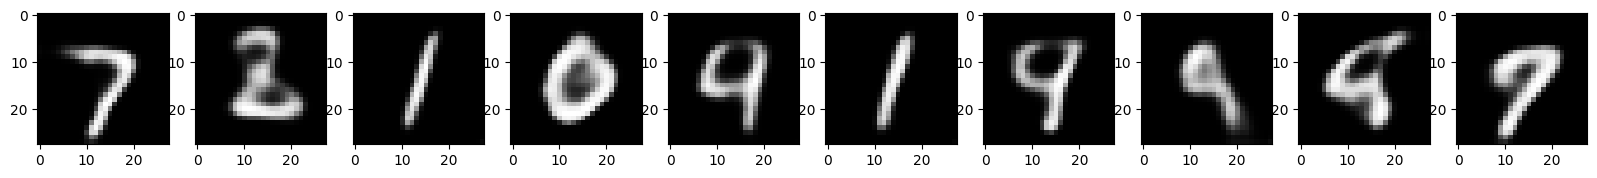

In [18]:
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(_query[i, ..., 0], cmap='gray')
plt.show()
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')
plt.show()

# Create Output In Latent Space

In [19]:
encoder_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense').output)


In [20]:
query_bottleneck_output = encoder_model.predict(_query)

313/313 [==============================] - 6s 19ms/step


In [21]:
query_bottleneck_output.shape

(10000, 10)

In [22]:
query_bottleneck_output*=255
query_bottleneck_output=query_bottleneck_output.astype(int)
query_bottleneck_output[0]

array([151, 228,  74, 133,  64, 133, 197, 196, 114,  77])

In [23]:
data_bottleneck_output = encoder_model.predict(_data)

1875/1875 [==============================] - 27s 14ms/step


In [24]:
data_bottleneck_output.shape

(60000, 10)

In [25]:
data_bottleneck_output*=255
data_bottleneck_output=data_bottleneck_output.astype(int)
data_bottleneck_output[0]

array([ 65, 179, 170, 152,  81,  53, 161,  38, 165, 132])

In [26]:
data_bottleneck_output[0]

array([ 65, 179, 170, 152,  81,  53, 161,  38, 165, 132])

In [27]:
np.savetxt(output_dataset_file, data_bottleneck_output, delimiter=',', fmt='%d')
np.savetxt(output_query_file, query_bottleneck_output, delimiter=',', fmt='%d')
